In [146]:
import numpy as np
import networkx as nx
import scipy.integrate as odeint
import kuramoto as kr
import matplotlib as mpl
import matplotlib.pyplot as plt
import math 
import csv
from colour import Color 


In [147]:

# class Oscillator:
#     def __init__(self,nat):
#         self.nat = nat  # nat freq of oscillator
        
#     def update(self,int): # function takes in a interaction 
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
def rgb_spectrum_line(value): # NEEDS OPACITY AND TUNING 
    if value == 0: 
        rgb = np.array([1.0,1.0,1.0]) # white 
    elif value < 0:
        rgb = abs(value)*np.array([1.0,0.0,0.0]) # yellow if < 0 
    else:
        rgb = abs(value)*np.array([0.0,0.0,1.0]) # blue >0
    return rgb
        

class Net:
    def __init__(self,Adj,n,k,dt,var,mean):
        self.Adj = Adj#Adjacency with weighted and dircetional couplings
        self.n = n
        self.dt = dt
        self.k = k
        self.space = [] #3 dimensional vectors in node based vector. 
        # NEEDS GENERATOR
        self.state = np.random.uniform(-2*np.pi,2*np.pi,(n,1)) # nx1 vector of current oscillator  states
        print('init state = {}'.format(self.state))
        self.nats =  2*np.pi*dt*np.random.normal(mean,var,(n,1)) # Vector of natural freqs, currently all unity for simplicity. 
        print('init nats = {}'.format(self.nats))
        self.I = np.zeros((n,1))
        self.noise_A = 0.5*np.sqrt(dt)
        self.graph = nx.from_numpy_array(self.Adj)
        self.pos = nx.kamada_kawai_layout(self.graph)
        
    def Gauss_Space(self,space_mean,space_var):
        self.space = np.random.normal(space_mean,space_var,(self.n,2))
        self.pos = self.space
 
    def distribute_adj(self,distribution):
        if distribution == 'uni':
            self.Adj = self.Adj * np.random.uniform(-1,1,self.Adj.shape)

        
    def Connect(self,a,P_inhib):
        # -a is power law exponent
        for i in range(self.n-1):
            for j in range(i+1,self.n): 
                if j != i:
                    pool = np.zeros([10000,1])
                    inhib_pool = np.ones([10000,1])
                    xi = self.space[i,:]
                    xj = self.space[j,:]
                    s = np.abs(xi-xj)
                    mag = np.sqrt(s[0]**2 + s[1]**2)# + s[2]**2 )
                    prob_connect = 1/(mag**a+1) # connection law. +1 is offset to normalise ## CHANGE to control connectivity
                    connect_num = np.round(len(pool)*prob_connect)
                    pool[1:int(connect_num)] = 1
                    np.random.shuffle(pool)
                    inhib_num = np.round(len(pool)*P_inhib)
                    pool[1:int(inhib_num)] = -1
                    np.random.shuffle(inhib_pool)
                    self.Adj[i,j] = (1/mag)*pool[np.random.randint(0,len(pool))]*inhib_pool[np.random.randint(0,len(pool))]
                    self.Adj[j,i] = (1/mag)*pool[np.random.randint(0,len(pool))]*inhib_pool[np.random.randint(0,len(pool))]
                else:
                    continue
        
    def Update(self):
    
        for i in range(self.n):
            I_n = 0
            for j in range(self.n):
                if self.Adj[i,j] != 0:
                    I_n += self.Adj[i,j]*np.sin(self.state[j] - self.state[i])*self.dt # update value of phase
                if i != j:    
                   self.Adj[i,j] += np.cos(self.state[j] - self.state[i])*self.dt # update coupling
            self.I[i] = I_n 
        #print('pre state = {}'.format(self.state))
        self.state += self.nats + self.I  #+ self.noise_A*np.random.randn(self.n,1)
        #print('post state = {}'.format(self.state))
        
    def View(self):
        self.graph = nx.from_numpy_array(self.Adj)
        #edge colours should be realted to normalised weights 
        
        #node colours should be current phase
        color_map = []
        # for i in range(self.n):
        #     color_map.append(cyclic_rgb(self.state[i]))
        # print(color_map)  
        Order = np.arange(0, self.n, 2)
        Order = np.hstack((Order, np.arange(self.n-1, 0, -2)))
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 8))
        ax = axs[0]
        # colormap(jet)
        ax.pcolormesh(self.Adj[Order, :][:, Order],cmap=mpl.colormaps['Spectral'])

        ax.set_xlabel('Nodes')
        ax.set_ylabel('Nodes')
        ax.set_title('Coupling Matrix')
        ax.axis('square')
        red = Color("red")
        colors = list(red.range_to(Color("green"),10))
        #nx.draw(self.graph,node_color=color_map,pos=self.pos) # BROKEN WITH EVOLUTIONS 
        
        
        ax = axs[1]
        # normalise weights
        norm_adj = np.zeros_like(self.Adj) 
        signed_norm_adj = np.zeros_like(self.Adj) 
        for i in range(0,self.n):
            for j in range(0,self.n):    
                norm_adj[i,j] = (abs(self.Adj[i,j]) - abs(self.Adj).min())/(abs(self.Adj).max() - abs(self.Adj).min())*(1)
            signed_norm_adj = norm_adj*np.sign(self.Adj)
        #print(norm_adj)
        for i in range(0,self.n):
            
            for j in range(i,self.n):
                print(rgb_spectrum_line(norm_adj[i,j]))
                plt.plot([self.pos[i][0],self.pos[j][0]],[self.pos[i][1],self.pos[j][1]],linestyle = '-',color = rgb_spectrum_line(signed_norm_adj[i,j]),alpha = norm_adj[i,j])
            plt.scatter(self.pos[i][0],self.pos[i][1])
            
            
        # ax = axs[2]
        # pos_phase = [np.cos(self.state),np.sin(self.state)]
        # for i in range(0,self.n):
        #     for j in range(0,self.n):    
        #         norm_adj[i,j] = (abs(self.Adj[i,j]) - abs(self.Adj).min())/(abs(self.Adj).max() - abs(self.Adj).min())*(1)
        #     signed_norm_adj = norm_adj*np.sign(self.Adj)
        # #print(norm_adj)
        # for i in range(0,self.n):
            
        #     for j in range(i,self.n):
        #         print(rgb_spectrum_line(norm_adj[i,j]))
        #         plt.plot([pos_phase[i][0],pos_phase[j][0]],[pos_phase[i][1],pos_phase[j][1]],linestyle = '-',color = rgb_spectrum_line(signed_norm_adj[i,j]),alpha = norm_adj[i,j])
        #     plt.scatter(pos_phase[i][0],pos_phase[i][1])
        
        
                
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''       
        # print('th0 {}'.format(self.state))
        # self.sins = np.sin(np.subtract.outer(self.state, np.transpose(self.state))) #sines of differences
        # #print(np.outer(self.state, np.transpose(self.state)))
        # #print('sin {}'.format(np.sin(np.subtract.outer(self.state, np.transpose(self.state)))))
        
        # #print('sins {}'.format(self.sins))
        # self.I = np.sum(np.multiply(self.Adj,self.sins), axis=0) # I is sum of contributions on each oscillator
        # print(np.multiply(self.Adj,self.sins))
        # print('I {}'.format(self.I))
        # self.state += self.nats + self.I
        # #print('nat = {}'.format(self.nats*dt))
        # #print('th1 {}'.format(self.state))
       
''' 
Can't interact with adjacency here 
''' 
    # def theta_dot(self,t,angles_vec):
    #     angles_i, angles_j = np.meshgrid(angles_vec, angles_vec)
    #     I = self.Adj* np.sin(angles_j - angles_i)
    #     dxdt = self.nats + I.sum(axis=0)
    #     return dxdt
    
    # def Run(self,dt,T):
    #     t = np.linspace(0, self.T, int(self.T/self.dt))
    #     timeseries = odeint(self.derivative, self.state, t)
    #     return timeseries
        
        


" \nCan't interact with adjacency here \n"

init state = [[ 0.06092592]
 [-2.68545483]
 [ 1.22295673]
 [-4.29742407]
 [-2.49444725]
 [-3.50473039]
 [ 6.22996212]
 [-1.8841004 ]
 [ 5.46300439]
 [ 0.32410969]]
init nats = [[ 5.01813451e-05]
 [-1.08313262e-04]
 [-2.36836324e-05]
 [-7.30627647e-05]
 [ 6.40861746e-05]
 [-4.18437190e-05]
 [ 3.32606933e-05]
 [-1.18713118e-05]
 [ 1.10592469e-05]
 [ 1.10190575e-04]]
new adj[[ 0.         -0.90907318 -0.56272935 -0.89530959 -0.53937307 -0.73708717
   0.09630394 -0.27322643  0.60441258  0.75698812]
 [ 0.65596911 -0.         -0.69661269 -0.3340663  -0.54698328 -0.52884233
   0.45104395 -0.59803077 -0.75339328 -0.97277884]
 [-0.17059201  0.64785218  0.          0.14117974  0.03086872 -0.68632405
   0.36130032  0.22670855  0.32008833  0.27368306]
 [ 0.84531598 -0.78636085 -0.55344164  0.         -0.36235171  0.96362503
   0.93705424  0.61217088 -0.65809935  0.15824746]
 [ 0.20764578  0.61608903  0.02849968 -0.74760283  0.         -0.43484344
   0.57484559  0.71427102 -0.59302334 -0.23738264]
 

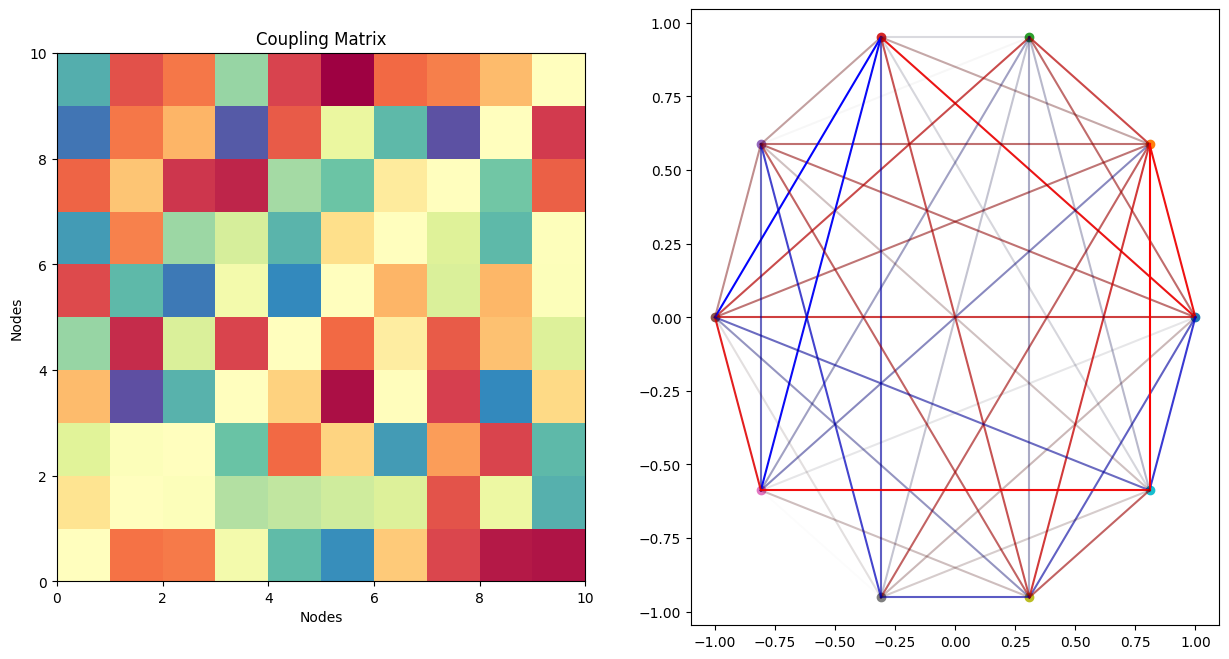

In [148]:
# test = [[0,10],[10,0]] # test adj with linear coupling
# testnet = Net(test,2)
# print(testnet.nats)
N = 10
k = 1
connectivity = 1
var,mean = 0.01, 0 

T = 10
res = 10000
time = np.linspace(0,T,res)
dt = T/res
results = np.zeros((res,N))
evo_adj = np.zeros((N,N,res))
graph_nx = nx.erdos_renyi_graph(n=N, p=connectivity) # p=1 -> all-to-all connectivity
graph = nx.to_numpy_array(graph_nx)*k
# graph = [[0,1,2],
#          [1,0,2],
#          [2,1,0]]
testnet = Net(graph,N,k,dt,var,mean)

testnet.distribute_adj('uni')
print(f'new adj{testnet.Adj}')

testnet.View()

In [149]:

# T = 1
# res = 30
# time = np.linspace(0,T,res)
# dt = T/res
results = np.zeros((res,N))



for i in range(0,len(time)):
    # print(np.mean(np.sin(testnet.state)))
    # print(np.shape(results))
    # print(np.shape(results[999]))
    results[i,:] = np.sin(testnet.state[:,0]) 
    #evo_adj[:,:,i] = testnet.Adj
    # plt.clf
    # ax.pcolormesh(testnet.Adj[Order, :][:, Order])
    # plt.pause(0.0001)
    # ax.set_xlabel('Nodes')
    # ax.set_ylabel('Nodes')
    # ax.set_title('Coupling Matrix')
    # ax.axis('square')
    testnet.Update()


Text(0, 0.5, 'Order Parameter')

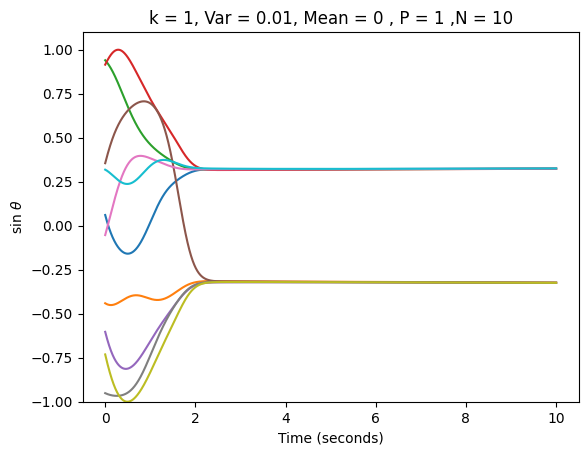

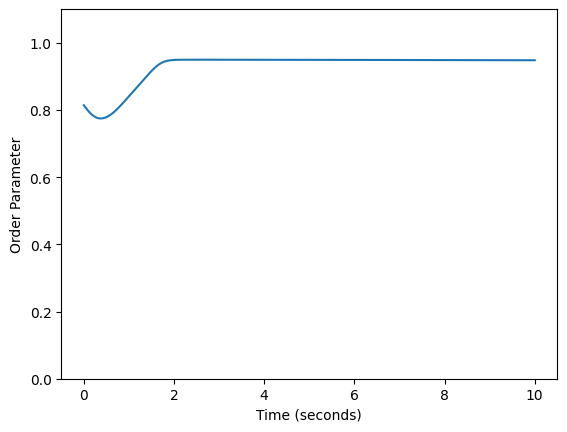

In [150]:
fig, ax = plt.subplots()
for i in range(N):
    ax.plot(time,results[:,i]) 
    
ax.set_ylim([-1, 1.1])

ax.set_xlabel('Time (seconds)')
ax.set_ylabel(r"sin $\theta $")
ax.set_title(f'k = {k}, Var = {var}, Mean = {mean} , P = {connectivity} ,N = {N}')
fig, ax = plt.subplots()
# print(np.exp(1j*results))
# print(np.mean(np.exp(1j*results)))
OP = np.abs(np.mean(np.exp(1j*results), axis=1))
ax.plot(time, OP)
ax.set_ylim([0, 1.1])


ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Order Parameter')

[1. 1. 1.]
[0.         0.         0.98092932]
[0.         0.         0.82462462]
[0.         0.         0.74576044]
[0.         0.         0.91801796]
[0.         0.         0.94921074]
[0.         0.         0.91211262]
[0.         0.         0.86659967]
[0.         0.         0.74598805]
[0.         0.         0.97387375]
[1. 1. 1.]
[0.         0.         0.96853879]
[0.         0.         0.90453853]
[0.         0.         0.85345111]
[0.         0.         0.78723632]
[0.         0.         0.86901915]
[0.         0.         0.83202146]
[0.         0.         0.78323691]
[0. 0. 1.]
[1. 1. 1.]
[0.        0.        0.9102875]
[0.         0.         0.90573291]
[0.         0.         0.86798936]
[0.         0.         0.92914909]
[0.         0.         0.88295418]
[0.         0.         0.85091063]
[0.         0.         0.92375543]
[1. 1. 1.]
[0.         0.         0.93027841]
[0.         0.         0.65870138]
[0.         0.         0.94611631]
[0.         0.         0.85298705]
[0.

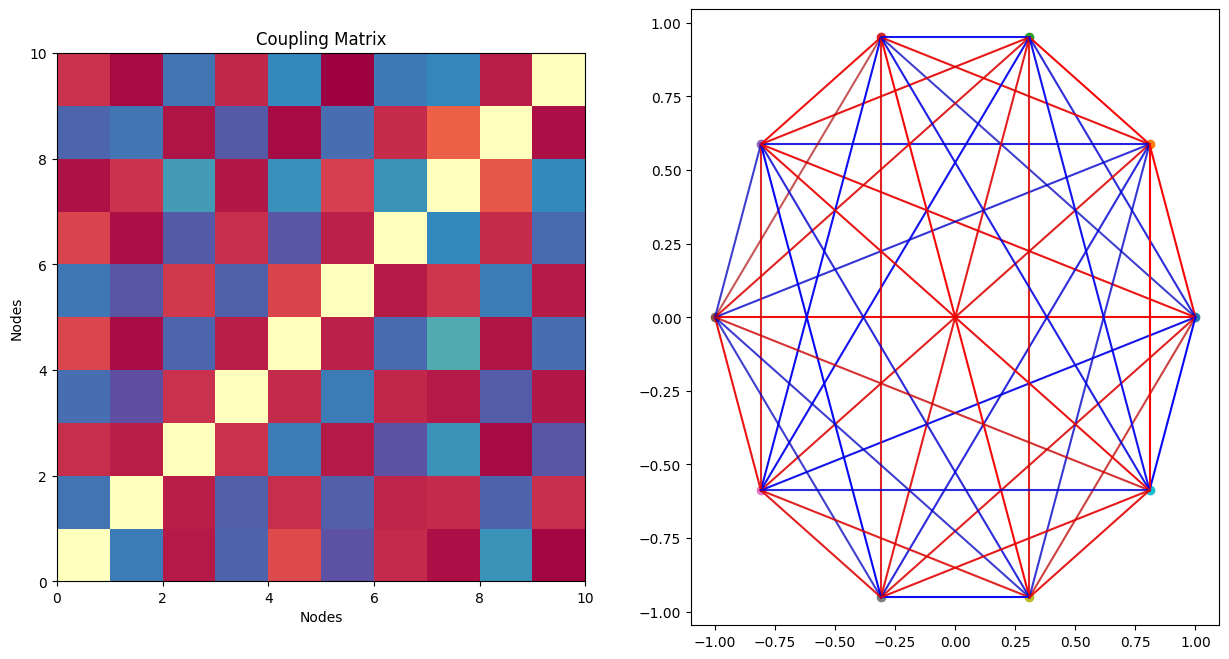

In [151]:

testnet.View()
#plt.colorbar()

# ax = axs[1]
# X = np.sin(results[:,i])
# FC = (X[:, None, :] * X[None, :, :]).mean(axis=0)
# ax.pcolormesh(FC[Order, :][:, Order])
# ax.set_xlabel('Nodes')
# ax.set_ylabel('Nodes')
# ax.set_title('Correlation Matrix')
# ax.axis('square')
#plt.colorbar()

In [152]:
print(testnet.Adj)

[[  0.         -10.75054755   9.03751779   8.17320161 -10.06106712
  -10.40292603   9.99634723  -9.49754556  -8.17569602  10.67322167]
 [ -9.18550525  -0.         -10.61475287  -9.91333857   9.3534432
    8.62775867  -9.52406201   9.11858386   8.58392697 -10.95955366]
 [  9.42965514  -9.27028799   0.           9.97634469  -9.9264284
   -9.51277598  10.1830593   -9.67678368  -9.32560069  10.12394724]
 [  9.91382718 -10.36563312   9.28172331   0.         -10.19543619
   -7.21907308  10.36901245  -9.34835739 -10.61725483   9.60564023]
 [ -9.31404828  10.51651551  -9.92879744 -10.58068731   0.
    8.23221086  -9.2459825   10.65377024   9.0823602  -10.05744361]
 [-10.28139955   8.52402809  -9.12664414  -7.6262249    7.86735474
    0.         -10.15026465   8.2073761    8.31122084  -8.74325905]
 [  9.56066228 -10.190348    10.79822227  10.21026288  -9.18688484
  -10.06346502   0.          -9.5994072   -9.43584754   9.06676495]
 [ -8.50986267   9.74108146 -10.42131643  -9.34911694  10.3724038

# Parameter Sweeps


In [153]:
## Saving functionality 
'''
Save file is set as N,k,p,var,mean
''' 
f = open(f'C:\\Users\\Harri\\OneDrive - The University of Manchester\\PhD\\Code\\Bayesian\\Python_Compsol\\{N}_{k}_{connectivity}_{mean}_{var}','w')
writer = csv.writer(f)

header = ['t']
for i in range(N):
    header.append(f'theta_{i+1}')
writer.writerow(header)
f.close()





In [154]:
print(testnet.pos)
print(type(testnet.pos))

{0: array([1.00000000e+00, 1.22227662e-08]), 1: array([0.80901699, 0.58778526]), 2: array([0.30901698, 0.95105654]), 3: array([-0.30901701,  0.95105649]), 4: array([-0.80901701,  0.58778524]), 5: array([-9.99999997e-01, -3.35153871e-08]), 6: array([-0.80901695, -0.58778526]), 7: array([-0.30901701, -0.95105651]), 8: array([ 0.30901704, -0.9510565 ]), 9: array([ 0.80901697, -0.58778524])}
<class 'dict'>
